In [4]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

import keras
assert keras.__version__ == "2.1.6"
print(keras.__version__)

# Root directory of the project
ROOT_DIR = os.path.abspath("./")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mrcnn", "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

TensorFlow 1.x selected.
1.15.2
2.1.6


Using TensorFlow backend.


In [5]:
class GrapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "grapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    LEARNING_RATE = 0.0005

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + grape

    # # generate more proposals.
    # RPN_NMS_THRESHOLD = 0.9
    # TRAIN_ROIS_PER_IMAGE = 512

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.5

    
config = GrapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0005
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [7]:
TRAIN_DIR = os.path.join(ROOT_DIR, "wgisd/train")
TEST_DIR = os.path.join(ROOT_DIR, "wgisd/test")

In [ ]:
# save the filename of train/test set
# TRAINSET_IMAGE_IDS = open("./wgisd/train_masked.txt", "r").read().splitlines()
# TEST_IMAGE_IDS = open("./wgisd/test_masked.txt", "r").read().splitlines()[:-1]

# img_aug_paremeter = 4
# AUG_IMAGE_IDS = []
# for id in TRAINSET_IMAGE_IDS:
#     for i in range(img_aug_paremeter):
#         new_id = id + '_' + str(i)
#         AUG_IMAGE_IDS.append(new_id)
# TRAINSET_IMAGE_IDS += AUG_IMAGE_IDS

In [ ]:
# import random
# random.shuffle(TRAINSET_IMAGE_IDS)
# val_len = int(len(TRAINSET_IMAGE_IDS)*0.2)
# VAL_IMAGE_IDS = TRAINSET_IMAGE_IDS[:val_len]
# TRAIN_IMAGE_IDS = list(set(TRAINSET_IMAGE_IDS) - set(VAL_IMAGE_IDS))
# assert list(set(VAL_IMAGE_IDS).intersection(set(TRAIN_IMAGE_IDS))) == []

In [ ]:
# print(VAL_IMAGE_IDS)
# print(TRAIN_IMAGE_IDS)
# print(TEST_IMAGE_IDS)

In [9]:
VAL_IMAGE_IDS = ['SYH_2017-04-27_1253_1', 'CDY_2018_3', 'SVB_20180427_152328332_HDR', 'CDY_20180427_153310519_BURST000_COVER_TOP_3', 'CSV_1899_3', 'SYH_2017-04-27_1233_1', 'SVB_1955_2', 'SYH_2017-04-27_1268', 'CDY_2031_0', 'SYH_2017-04-27_1300_1', 'CFR_1626_1', 'CSV_1883_0', 'CFR_1620_0', 'SYH_2017-04-27_1271', 'SVB_1973_3', 'SVB_1947_2', 'CFR_1654_0', 'CDY_2028_0', 'CDY_2019_2', 'SVB_1971', 'CSV_1865', 'CFR_1671_2', 'SVB_1976_1', 'CFR_1652_1', 'CDY_20180427_153021423_BURST001', 'SYH_2017-04-27_1236', 'CSV_1886_1', 'SYH_2017-04-27_1294_3', 'SVB_1947_0', 'CFR_1647_0', 'SYH_2017-04-27_1280_0', 'CFR_1647_3', 'CDY_2056_2', 'CDY_20180427_153310519_BURST000_COVER_TOP_0', 'CSV_1881_1', 'CFR_1647_1', 'CSV_1868_3', 'CDY_2050_3', 'SVB_1951_3', 'CDY_20180427_153144437_BURST000_COVER_TOP', 'CSV_20180427_144622111_HDR_0', 'CFR_1635_2', 'CFR_1660_0', 'SVB_1973_0', 'CSV_1871_2', 'SYH_2017-04-27_1310_0', 'CDY_2019_1', 'CFR_1652', 'SVB_1950_0', 'CDY_2028_2', 'SVB_1931_1', 'CDY_2027_0', 'CFR_1647', 'CDY_2048_3', 'CFR_1635_3', 'CFR_1671', 'CSV_1881', 'CFR_20180427_141236326_0', 'CFR_1652_2', 'CDY_20180427_153021423_BURST001_3', 'CFR_1661_0', 'CSV_20180427_144528920_3', 'CFR_1650_0', 'SVB_1977_2', 'SYH_2017-04-27_1300_0', 'SVB_20180427_152106643_HDR', 'CSV_1882_3', 'CDY_20180427_153310519_BURST000_COVER_TOP_2', 'CFR_1670_0', 'CDY_2018_0', 'CFR_1670', 'SYH_2017-04-27_1316', 'CDY_2052_0', 'SVB_1971_0', 'SVB_1939', 'CFR_20180427_141115778_HDR_1', 'CSV_1871_1', 'CDY_2017_2', 'CSV_1871_0', 'CDY_20180427_153310519_BURST000_COVER_TOP_1', 'CDY_2024_3', 'CSV_1886_0', 'SVB_1931_3', 'CSV_1901', 'CFR_1633_1', 'CFR_1635_1', 'SVB_1967_2', 'CSV_20180427_144513954_2', 'SYH_2017-04-27_1332_1', 'CDY_2017_0', 'SYH_2017-04-27_1251_0', 'SVB_1977_0', 'CSV_1891_2', 'CFR_20180427_141158495_3', 'SVB_1967_0', 'CFR_20180427_141030745_HDR', 'CFR_1624', 'CDY_2017_1', 'SYH_2017-04-27_1280_1', 'SVB_20180427_152414932_HDR_1', 'CFR_1650_3', 'SYH_2017-04-27_1311_0', 'CDY_2050_2', 'CSV_1891', 'SVB_1957_0', 'SYH_2017-04-27_1233', 'CSV_1886_2', 'CDY_2042_2', 'CSV_1911_2', 'SVB_1937_2']
TRAIN_IMAGE_IDS = ['SVB_1951', 'CFR_20180427_141030745_HDR_3', 'SYH_2017-04-27_1300_3', 'CFR_20180427_141236326_3', 'CDY_2018_1', 'CFR_1627', 'SVB_1931_0', 'SYH_2017-04-27_1311_2', 'CSV_1911_0', 'CSV_1883_2', 'SYH_2017-04-27_1236_3', 'CFR_1631_1', 'SYH_2017-04-27_1312', 'SYH_2017-04-27_1310', 'SVB_1971_2', 'CDY_20180427_152937457_BURST000_COVER_TOP_3', 'CFR_1635_0', 'CFR_20180427_141158495_1', 'CDY_2048_2', 'SYH_2017-04-27_1238_2', 'CSV_20180427_144556277_1', 'CSV_1874_3', 'CFR_1661_2', 'SVB_1978_3', 'CFR_1633_3', 'SVB_1960', 'CDY_20180427_153021423_BURST001_1', 'CFR_1642_0', 'SYH_2017-04-27_1312_1', 'SVB_1973_2', 'CSV_20180427_144528920_2', 'CFR_1642_3', 'SVB_1973_1', 'CFR_1631_0', 'SVB_1957_2', 'CFR_1670_3', 'CFR_1663_0', 'CFR_1662_2', 'CDY_2034_0', 'CFR_20180427_141254316_HDR_2', 'CFR_1624_0', 'CFR_1661', 'CFR_1664', 'CSV_20180427_144556277', 'CSV_20180427_144622111_HDR', 'CSV_1882', 'CFR_20180427_141254316_HDR_3', 'SVB_1976_2', 'CDY_2034_3', 'SVB_1977_3', 'CFR_1631', 'CSV_1874_1', 'CDY_2019', 'CFR_1663', 'CDY_2061_3', 'CFR_1627_1', 'CSV_1901_0', 'CFR_20180427_141115778_HDR_0', 'SYH_2017-04-27_1332_3', 'CSV_1873_1', 'CDY_2050_0', 'CFR_1654_2', 'CDY_2028_3', 'CSV_1891_0', 'CFR_1642', 'CSV_1883_1', 'CFR_1626_3', 'SYH_2017-04-27_1233_0', 'SVB_1939_2', 'SVB_1967_1', 'CFR_1662', 'CFR_1627_3', 'CFR_20180427_141158495_2', 'SYH_2017-04-27_1236_2', 'SYH_2017-04-27_1268_2', 'CFR_1654_1', 'CSV_1903', 'CDY_2019_3', 'SVB_20180427_151954938_HDR_1', 'CFR_1663_3', 'CSV_20180427_144556277_3', 'SYH_2017-04-27_1271_3', 'CSV_1874_0', 'SVB_1973', 'CFR_1650_1', 'CSV_20180427_144615644_1', 'CSV_1873_3', 'SVB_1971_3', 'CSV_1899_1', 'CDY_2027_3', 'CSV_1878_2', 'CDY_20180427_153144437_BURST000_COVER_TOP_3', 'SVB_1957_1', 'SVB_1969_1', 'SVB_1938_3', 'SYH_2017-04-27_1271_0', 'CDY_20180427_153310519_BURST000_COVER_TOP', 'CFR_20180427_141128570_0', 'CFR_1645_1', 'CDY_20180427_153144437_BURST000_COVER_TOP_0', 'SVB_1938_0', 'CSV_1882_0', 'SVB_20180427_152106643_HDR_0', 'CDY_2031', 'CFR_1652_0', 'SVB_20180427_152328332_HDR_0', 'CSV_1871_3', 'CFR_1645_2', 'CFR_1662_3', 'CSV_1865_0', 'SYH_2017-04-27_1332_0', 'CDY_2061', 'SYH_2017-04-27_1310_3', 'CFR_20180427_141128570_1', 'CFR_1620_1', 'CFR_20180427_141030745_HDR_0', 'CFR_1664_2', 'SYH_2017-04-27_1241_1', 'SYH_2017-04-27_1294', 'CSV_1873_2', 'SYH_2017-04-27_1251_2', 'CSV_1883_3', 'CSV_20180427_144622111_HDR_3', 'CDY_2028', 'SVB_20180427_152414932_HDR_0', 'CSV_1886', 'SVB_1960_1', 'SVB_1937_0', 'CFR_1624_3', 'SVB_1950_2', 'SYH_2017-04-27_1300_2', 'SVB_20180427_152328332_HDR_2', 'CDY_2061_0', 'CDY_2024', 'SYH_2017-04-27_1260', 'CSV_1893_1', 'CFR_20180427_141128570', 'SVB_1966_2', 'CFR_1628_1', 'CFR_1661_1', 'SYH_2017-04-27_1233_3', 'CDY_2017', 'CDY_2048_0', 'CFR_20180427_141115778_HDR_3', 'CFR_1660', 'CFR_20180427_141115778_HDR_2', 'SYH_2017-04-27_1336_1', 'SVB_1946', 'CDY_2061_2', 'SYH_2017-04-27_1271_2', 'CDY_2052_2', 'CSV_1903_3', 'CSV_1878', 'SYH_2017-04-27_1236_0', 'SVB_1938', 'CFR_1628_0', 'CSV_1897_3', 'SYH_2017-04-27_1241_0', 'SYH_2017-04-27_1280_2', 'CSV_1897', 'CSV_1865_1', 'CSV_20180427_144615644_3', 'CFR_20180427_141236326_2', 'CDY_2027', 'CFR_1663_2', 'CFR_1631_2', 'CFR_1660_3', 'CDY_2034_2', 'CSV_1893_3', 'SYH_2017-04-27_1312_0', 'CDY_2052_3', 'SVB_20180427_151954938_HDR_3', 'SVB_20180427_151954938_HDR_0', 'CDY_2042_1', 'SVB_1969_2', 'CSV_1865_3', 'CFR_20180427_141128570_2', 'SYH_2017-04-27_1268_0', 'SVB_1971_1', 'CDY_2024_1', 'CDY_2031_3', 'CDY_2024_2', 'SYH_2017-04-27_1251', 'CDY_20180427_152937457_BURST000_COVER_TOP_2', 'SYH_2017-04-27_1316_2', 'CDY_20180427_152937457_BURST000_COVER_TOP_1', 'CSV_1881_3', 'CFR_1628', 'SVB_1976_0', 'SVB_20180427_152328332_HDR_1', 'CFR_1626_2', 'CFR_1662_1', 'SVB_1950_3', 'SYH_2017-04-27_1312_2', 'CSV_20180427_144556277_2', 'CFR_1647_2', 'SYH_2017-04-27_1332_2', 'SVB_1951_2', 'SVB_1966_3', 'CFR_1633_2', 'CFR_1626', 'CFR_1660_2', 'CSV_1889_2', 'CDY_2024_0', 'CSV_1897_2', 'CDY_2027_1', 'SVB_1966_0', 'SVB_1976', 'CDY_2018', 'CDY_2019_0', 'SVB_1969_3', 'SYH_2017-04-27_1268_3', 'CDY_2048_1', 'SVB_1966', 'SVB_1938_1', 'CFR_1620_3', 'SVB_20180427_152106643_HDR_3', 'CFR_1642_1', 'SYH_2017-04-27_1271_1', 'CDY_20180427_152937457_BURST000_COVER_TOP_0', 'CSV_1882_2', 'CFR_20180427_141030745_HDR_2', 'CSV_1897_0', 'CFR_1631_3', 'CSV_1881_0', 'CFR_1633', 'CSV_1893_0', 'SYH_2017-04-27_1310_2', 'CDY_20180427_153021423_BURST001_0', 'CFR_1654_3', 'CSV_20180427_144528920_0', 'CDY_2042', 'SYH_2017-04-27_1241_3', 'SVB_1977', 'CSV_1891_3', 'SVB_20180427_152106643_HDR_2', 'SYH_2017-04-27_1238', 'SVB_1931', 'CSV_1881_2', 'SVB_1955_1', 'CSV_1882_1', 'SVB_1978', 'CSV_20180427_144615644', 'SYH_2017-04-27_1253_3', 'CFR_20180427_141236326_1', 'CDY_2027_2', 'CSV_1893_2', 'SYH_2017-04-27_1311_1', 'CFR_1664_0', 'SVB_20180427_152328332_HDR_3', 'CDY_2056_0', 'CSV_1899_2', 'SVB_1974', 'CSV_1874', 'CSV_1903_1', 'CSV_1868_2', 'CFR_1624_1', 'CSV_1893', 'SVB_1969', 'CDY_2052_1', 'CDY_2050_1', 'SVB_1937_3', 'CDY_2056_3', 'CSV_1889_1', 'CDY_20180427_152937457_BURST000_COVER_TOP', 'CSV_1868_1', 'CFR_1645_3', 'CDY_2052', 'CDY_2056_1', 'CSV_1878_3', 'CSV_1901_3', 'CDY_2031_2', 'CFR_1650', 'CSV_1911', 'SVB_1978_2', 'CDY_20180427_153144437_BURST000_COVER_TOP_1', 'CSV_20180427_144513954_0', 'SYH_2017-04-27_1253', 'CFR_1670_2', 'SVB_1946_0', 'SYH_2017-04-27_1260_1', 'SYH_2017-04-27_1253_0', 'SVB_1951_1', 'CDY_2018_2', 'CSV_20180427_144513954_1', 'SVB_1931_2', 'SVB_1978_1', 'CFR_20180427_141254316_HDR', 'SYH_2017-04-27_1253_2', 'CFR_1663_1', 'CFR_1624_2', 'CSV_1899', 'SYH_2017-04-27_1260_3', 'SVB_1937_1', 'CFR_1628_3', 'SYH_2017-04-27_1316_1', 'CDY_2042_0', 'CFR_1654', 'SVB_1955_3', 'SVB_1957_3', 'CSV_1903_2', 'CSV_1874_2', 'SYH_2017-04-27_1316_0', 'SYH_2017-04-27_1280_3', 'SYH_2017-04-27_1316_3', 'SYH_2017-04-27_1294_1', 'CSV_1868', 'CSV_20180427_144556277_0', 'SVB_1947_1', 'CSV_1886_3', 'CDY_2050', 'SVB_1974_2', 'CSV_20180427_144513954_3', 'CFR_1642_2', 'SVB_1967', 'CSV_1889_0', 'SVB_1939_3', 'SVB_20180427_152414932_HDR_3', 'SVB_1967_3', 'SYH_2017-04-27_1241_2', 'CSV_20180427_144528920_1', 'SVB_1939_0', 'CFR_20180427_141030745_HDR_1', 'CSV_1883', 'SYH_2017-04-27_1336_2', 'SYH_2017-04-27_1251_3', 'SYH_2017-04-27_1238_1', 'CDY_20180427_153144437_BURST000_COVER_TOP_2', 'CFR_1633_0', 'SYH_2017-04-27_1311', 'CDY_2031_1', 'SYH_2017-04-27_1251_1', 'CFR_20180427_141115778_HDR', 'SYH_2017-04-27_1268_1', 'CFR_1627_2', 'CFR_1645_0', 'CFR_1650_2', 'CDY_2034_1', 'CSV_1873_0', 'CSV_1899_0', 'SVB_1955_0', 'CFR_1620', 'SYH_2017-04-27_1236_1', 'SVB_1946_1', 'SVB_1951_0', 'CSV_1901_1', 'SYH_2017-04-27_1238_3', 'CSV_20180427_144615644_2', 'CFR_1664_3', 'SVB_1960_3', 'SYH_2017-04-27_1294_0', 'CSV_1871', 'SVB_20180427_151954938_HDR', 'CSV_1878_0', 'SYH_2017-04-27_1311_3', 'CFR_20180427_141236326', 'CFR_1671_0', 'CFR_1660_1', 'SYH_2017-04-27_1241', 'CFR_20180427_141158495_0', 'CDY_2061_1', 'CFR_1627_0', 'SVB_1937', 'CSV_20180427_144615644_0', 'CSV_1868_0', 'SYH_2017-04-27_1336', 'CFR_20180427_141128570_3', 'CSV_1911_3', 'SYH_2017-04-27_1312_3', 'CFR_1635', 'SVB_1957', 'SVB_1946_2', 'SYH_2017-04-27_1260_0', 'SYH_2017-04-27_1336_0', 'CSV_1873', 'SYH_2017-04-27_1260_2', 'SVB_1974_1', 'SVB_1978_0', 'SVB_20180427_151954938_HDR_2', 'CFR_1620_2', 'CSV_1891_1', 'CFR_20180427_141158495', 'CDY_2034', 'CSV_1903_0', 'SVB_1946_3', 'CFR_1662_0', 'SYH_2017-04-27_1332', 'CFR_1664_1', 'SVB_1938_2', 'CSV_20180427_144528920', 'CSV_1897_1', 'CSV_1878_1', 'SYH_2017-04-27_1233_2', 'CDY_2056', 'CFR_1645', 'SVB_1977_1', 'CFR_20180427_141254316_HDR_1', 'SYH_2017-04-27_1280', 'CDY_2028_1', 'CSV_1901_2', 'CSV_20180427_144622111_HDR_2', 'CFR_1661_3', 'CSV_1865_2', 'CDY_2042_3', 'CDY_20180427_153021423_BURST001_2', 'SYH_2017-04-27_1300', 'SVB_1950_1', 'SVB_1974_3', 'SYH_2017-04-27_1336_3', 'CSV_20180427_144513954', 'SVB_1976_3', 'SVB_1974_0', 'SYH_2017-04-27_1238_0', 'SVB_1955', 'SVB_1960_0', 'SVB_1966_1', 'SVB_1950', 'SVB_1947', 'SVB_1960_2', 'CSV_1911_1', 'CFR_20180427_141254316_HDR_0', 'SVB_20180427_152414932_HDR', 'CSV_1889_3', 'SVB_1939_1', 'CSV_20180427_144622111_HDR_1', 'SYH_2017-04-27_1294_2', 'SYH_2017-04-27_1310_1', 'SVB_1969_0', 'CDY_2048', 'SVB_20180427_152414932_HDR_2', 'CFR_1670_1', 'SVB_1947_3', 'SVB_20180427_152106643_HDR_1', 'CSV_1889', 'CFR_1628_2', 'CFR_1671_3', 'CFR_1626_0', 'CFR_1671_1', 'CFR_1652_3', 'CDY_2017_3']
TEST_IMAGE_IDS = ['CFR_1639', 'SYH_2017-04-27_1318', 'CDY_2051', 'SVB_1935', 'CDY_2040', 'CSV_1898', 'CFR_1651', 'SYH_2017-04-27_1239', 'CFR_1666', 'SYH_2017-04-27_1322', 'SVB_20180427_151818928', 'SVB_1972', 'CSV_1877', 'CDY_2015', 'SYH_2017-04-27_1269', 'CFR_1638', 'CFR_1641', 'CFR_1643', 'SVB_1954', 'CDY_2054', 'CSV_20180427_144535647', 'CSV_20180427_144723166_HDR', 'CSV_20180427_144507419', 'SVB_1944', 'CDY_2043', 'CDY_2046', 'SYH_2017-04-27_1304']

In [10]:
class GrapesDataset(utils.Dataset):

    def load_grapes(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("grapes", 1, "grapes")

        # Train or validation dataset?
        assert subset in ["train", "val", "test"]
#         dataset_dir = os.path.join(dataset_dir, subset)

        if subset == "train":
            image_ids = TRAIN_IMAGE_IDS
        elif subset == "val":
            image_ids = VAL_IMAGE_IDS
        else:
            image_ids = TEST_IMAGE_IDS

        # Add images
        for image_id in image_ids:
            self.add_image(
                "grapes",
                image_id=image_id,
                path=os.path.join(dataset_dir, "{}.jpg".format(image_id)))

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        # Get mask directory from image path
        mask_path = os.path.join(os.path.dirname(info['path']), "{}.npz".format(info['id']))

        # Read mask files from .png image
        mask = np.load(mask_path)['arr_0']
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID, we return an array of ones
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "grapes":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [11]:
# Training dataset
dataset_train = GrapesDataset()
dataset_train.load_grapes(TRAIN_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = GrapesDataset()
dataset_val.load_grapes(TRAIN_DIR, "val")
dataset_val.prepare()

print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    
print("Image Count: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 440
Class Count: 2
  0. BG                                                
  1. grapes                                            
Image Count: 110
Class Count: 2
  0. BG                                                
  1. grapes                                            


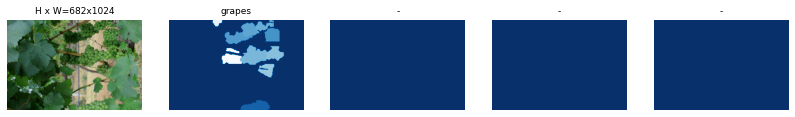

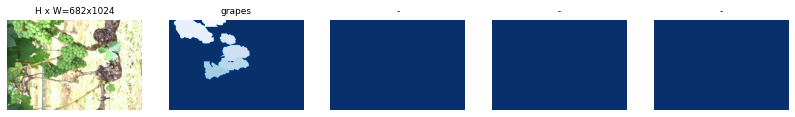

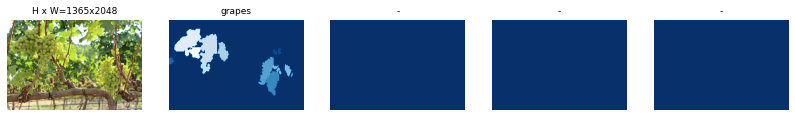

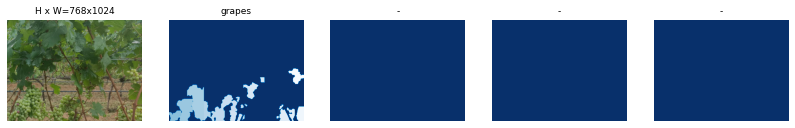

In [12]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








# Continue TRAINING form last epoch


In [ ]:
# Create model in training mode
# model = modellib.MaskRCNN(mode="training", config=config,model_dir=MODEL_DIR)
# model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 10


In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expr                         ession to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=15, 
            layers='all')


Starting at epoch 10. LR=0.0005

Checkpoint Path: /content/drive/MyDrive/726_grape_segmentation/logs/grapes20201215T1334/mask_rcnn_grapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b  

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers 

Epoch 11/15
 999/1000 [============================>.] - ETA: 1s - loss: 0.2370 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.1454

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 1255s 1s/step - loss: 0.2369 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.1454 - val_loss: 1.9239 - val_rpn_class_loss: 0.2175 - val_rpn_bbox_loss: 0.7557 - val_mrcnn_class_loss: 0.3483 - val_mrcnn_bbox_loss: 0.2790 - val_mrcnn_mask_loss: 0.3233
Epoch 12/15
1000/1000 [==============================] - 1157s 1s/step - loss: 0.2231 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0496 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.1408 - val_loss: 1.9276 - val_rpn_class_loss: 0.2501 - val_rpn_bbox_loss: 0.8494 - val_mrcnn_class_loss: 0.2631 - val_mrcnn_bbox_loss: 0.2569 - val_mrcnn_mask_loss: 0.3081
Epoch 13/15
1000/1000 [==============================] - 1150s 1s/step - loss: 0.2171 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0518 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0140 - mrcnn_mask_loss: 0.1358 - val_loss: 1.7542 - val_rpn_class_l

# Detection START HERE

In [13]:
class InferenceConfig(GrapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")

# using the last model
model_path = model.find_last()

# use earlier saved model
# model_path = "/content/drive/MyDrive/726_grape_segmentation/model/original_all_layers_detection_min_confidence05/mask_rcnn_grapes_0005.h5"

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/drive/MyDrive/726_grape_segmentation/logs/grapes20201215T1334/mask_rcnn_grapes_0015.h5






Re-starting from epoch 15


# Test on a random image on VAL set

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (12,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (12, 4)               min:    0.00000  max:  958.00000  int32
gt_mask                  shape: (1024, 1024, 12)      min:    0.00000  max:    1.00000  float64


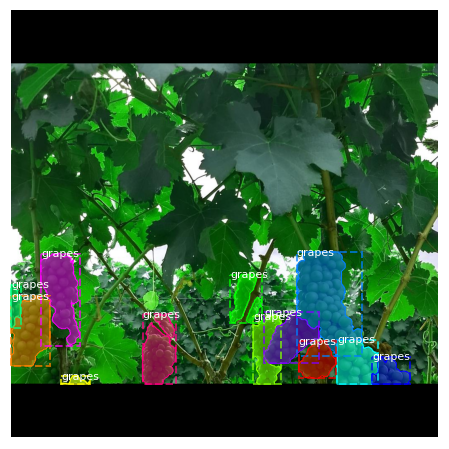

In [14]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [40]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP    
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.8996267130293629


# Test on a random image on TEST set

In [ ]:
TEST_IMAGE_IDS = open("./wgisd/test_masked.txt", "r").read().splitlines()[:-1]

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 2048.00000  float64
gt_class_id              shape: (26,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (26, 4)               min:    0.00000  max:  990.00000  int32
gt_mask                  shape: (1024, 1024, 26)      min:    0.00000  max:    1.00000  float64


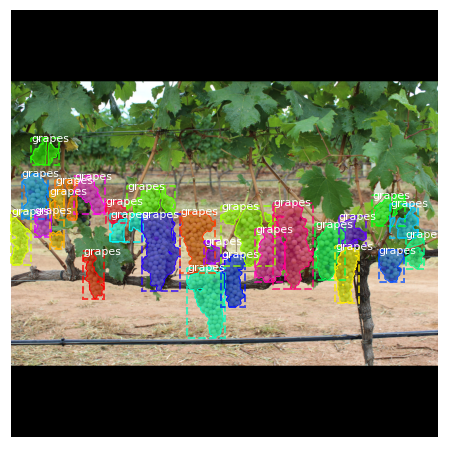

In [23]:
# Test on a random image
# Testing dataset
dataset_test = GrapesDataset()
dataset_test.load_grapes(TEST_DIR, "test")
dataset_test.prepare()


image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [29]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_test.image_ids, 10)

APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.8461170538634869
